In [59]:
# Overpass API
import overpy
# manipulation of geometric objects. Used for offsetting the trainlines
import shapely.geometry
# cartographic projections and coordinate transformations
import pyproj
# translating and manipulating point cloud data
import pdal
# lidar LAS file reading/writing
import laspy

import pandas as pd
import scipy.spatial
import ipyvolume.pylab as p3
import open3d as o3d
import numpy as np

import json
import IPython.display

# Railway Vegetation Detection:


In [147]:
# Input filename of the LIDAR tile you want to process
lidar_filename = input("Filename of LIDAR-Tile: ")

# if empty replace by example tile
if not lidar_filename:
    lidar_filename ="3dm_32_508_5707_1_nw.laz"

Filename of LIDAR-Tile: 


In [139]:

# get dimensions of the lidar data
with laspy.open(lidar_filename) as fh:
    x_min =fh.header.x_min
    x_max =fh.header.x_max  
    y_min =fh.header.y_min
    y_max =fh.header.y_max
    
# transformation to lat.,lon. coordinates
transformer = pyproj.Transformer.from_crs("epsg:25832", "epsg:4326")

# determine bounding box
# add a buffer of 20 meters to account for close by railways 
bbox = (*transformer.transform(x_min-20, y_min-20), *transformer.transform(x_max+20, y_max+20))

___
## Load and Process Train Lines from OSM:

We load the data of train lines within the specified region from open street map. 
As OSM uses a different coordinate reference system (CRS) than the LIDAR data, we need to reproject the coordinates into the right CRS.

The train lines are bufferd by a specified distance to create a mask for cropping the LIDAR data in the next step.
___

In [140]:
# Load all railway lines from OSM within the determined bounding box

api = overpy.Overpass()

osm_result = api.query(f"""
    [out:json][timeout:25];
    area["name"="Nordrhein-Westfalen"];
    (
      way["railway"="rail"]{bbox};
    );
    out body;
    >;
    out skel qt;
    """)


In [141]:

# transformation from lat.,lon. coordinates to European projection UTM32
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:25832")

# create list of all railway lines and reproject them into the right CRS
railway_lines = []
for way in osm_result.ways:
    nodes = [(node.lat, node.lon) for node in way.nodes]
    railway_lines.append([transformer.transform(lat, lon) for (lat,lon) in nodes])
    

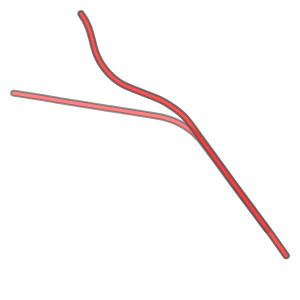

In [142]:
# create a buffer around all trainlines and colloect them in a multipolygon
railway_bufferd = shapely.geometry.MultiPolygon([shapely.geometry.LineString(railway).buffer(40) for railway in railway_lines])

# draw the railway lines
IPython.display.display(railway_bufferd)


___
## Processing of the LIDAR Point Cloud:

___

In [143]:
# process LIDAR data:
#    crop area around the trainlines
#    determine every points hight_above_ground and Eigenvalue
filters = {
    "pipeline": [ lidar_filename,
                 
        {   "type":"filters.crop",
            'polygon':railway_bufferd.wkt},
        {   "type":"filters.hag_delaunay"},
        {   "type":"filters.eigenvalues",
            "knn":16},
        #{   "type":"filters.normal",
        #    "knn":16}
    ]}

pipeline = pdal.Pipeline(json.dumps(filters))
%time n_points = pipeline.execute()
print('Pipeline selected {} points.'.format(n_points))

CPU times: total: 1min 59s
Wall time: 2min 25s
Pipeline selected 2314702 points.


In [144]:
# Load Pipeline output in python objects
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})

In [145]:
# determine which points are ground and which might be vegetation
df['ground'] = df['Classification']==2
df['flatness'] = df['Eigenvalue0']
df['vegetation'] = (df['ground']==0) & (df['Classification']==1) & (df['HeightAboveGround'] >= 0.5) & (df['flatness'] > .04) &  (df['NumberOfReturns'] - df['ReturnNumber'] >= 1)

# set colors of the points based on points intensity
# make vegetation points green
colors = np.array([np.log2(df["Intensity"]+1)/np.max(np.log2(df["Intensity"]+1)),
                   np.log2(df["Intensity"]+1)/np.max(np.log2(df["Intensity"]+1)),
                   np.log2(df["Intensity"]+1)/np.max(np.log2(df["Intensity"]+1))]).T
colors[df[df['vegetation']].index] = (0.1,0.6,0.2)

print("Num. of vegetation points: ", sum(df['vegetation']))
print("Num. of ground points:     ", sum(df['ground']))


Num. of vegetation points:  127416
Num. of ground points:      1846406


In [146]:
# show point cloud
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(np.array(df[["X","Y","Z"]]) 
                                         - np.array(np.min(df[["X","Y","Z"]], axis=0))) # shifting the datapoints for smoother visualization because of float imprecision   
geom.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([geom])


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Das Handle ist ungültig. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Das Handle ist ungültig. 


### Detect individual trees in the vegetation points:

In [50]:
# this pipeline sorts the data points by hight and then applies the Li tree algorithm.
tree_detector = """
{
  "pipeline": [
    {
        "type":"filters.sort",
        "dimension":"HeightAboveGround",
        "order":"DESC"
    },
    {
        "type":"filters.litree",
        "min_points":20,
        "min_height":2.5,
        "radius":100.0
    }
  ]
}
"""
# pass the vegetation points to the pipeline
# df is transformed to a structured numpy array.
# as pdal does not accepts boolean datatyped replace the datatype descriptor (dirty workaround)
structured_array = np.array([tuple(x) for x in df[df['vegetation']].values], dtype=list(zip(df.dtypes.index, df.dtypes.replace("bool", "uint8"))))
pipeline = pdal.Pipeline(tree_detector, arrays=[structured_array,])
%time result = pipeline.execute()

CPU times: total: 15min 8s
Wall time: 19min 27s


In [51]:
# Load Pipeline output in python objects
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})

In [53]:
# generate a random color for each tree
rnd_colors = np.array([np.random.uniform(size=3) for _ in range(max(df.ClusterID)+1)])
rnd_colors[0] = np.array([0.5,0.5,0.5])
colors = np.zeros((len(df), 3))
colors = rnd_colors[df.ClusterID]

In [88]:
# show point cloud
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(np.array(df[["X","Y","Z"]]) 
                                         - np.array(np.min(df[["X","Y","Z"]], axis=0))) # shifting the datapoints for smoother visualization because of float imprecision   
geom.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([geom])